In [ ]:
"""

BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.
GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to 
predict is called failure with binary value 0 for non-failure and 1 for failure.
    
APPROACH
The solution predicts the probability of a device failure within a given window (5 days considered here).
Exploratory data analysis was performed to understand the data better(trends, correlations), transform it and 
new predictors were created through feature engineering. Below were some observations
1. From the data it is clear that preventive maintenance is performed where devices are replaced when
       they reach a threshold # of days
2. 97% devices were replaced during the course, of which only 9% actually failed
3. There is a discontinuity in logs when devices are removed for maintenance, there are exceptions where
   5% of failed devices continued to have logs
4. There are 9 telemetry readings, metric 7 and 8 are the same and hence one is retained.
5. The dataset is grouped at a device-date level, new features engineered are changes in the mean, median 
   and std dev of devices over the course they are active, their cycle(active day #), and also their drift 
   from their initial value
6. The top predictors of failure within a given window are - no. of days a device has been in operation, metric6, 
   metric1 and deviation of metric 4 from average at a given point in time
7. A target variable is created that will predict probability of device failure in a given window
8. 3 models were built - Decision tree, Random Forest Classifier and XGBoost
9. Decision Tree does a better job at predicting the failure(positive) cases compared to Random Forest Classifier.
   Since the class was highly imbalanced, other metrics that were used to evaluate the model were
   Area under Precision-Recall curve and F1 score, Random Forest Classifier has better/comparable values for these
   metrics in comparision to the Decision Tree and XGBoost models
       
FUTURE CONSIDERATIONS:
1. Since the dataset is highly imbalanced, more data on the minority(positive) class can help improve the 
   classification
2. If more data cannot be provided, considering failure of a device is a rare event, this problem can be modeled
   as an anamoly detection problem to predict device failures
3. Although the aim was to minimize false positives and negatives, an understanding of cost associated with 
   error types from the business can help with tuning the algorithms and evaluating them

"""

In [2]:
#import all libraries needed for analyses
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, auc, classification_report, recall_score, precision_score, roc_auc_score, precision_recall_curve, roc_curve, plot_confusion_matrix
from time import sleep
import itertools
import numpy as np
from matplotlib import pyplot

In [3]:
#load the dataset
pred_mnt = pd.read_csv('predictive_maintenance.csv')
print(pred_mnt.head())
print("\n no. of rows and cols in the dataset")
print(pred_mnt.shape)

     date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/15  S1F01085        0  215630672       56        0       52        6   
1  1/1/15  S1F0166B        0   61370680        0        3        0        6   
2  1/1/15  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/15  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/15  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  

 no. of rows and cols in the dataset
(124494, 12)


In [4]:
# daily logs from 01/15 - 09/15
#metrics 2,34,7,8 & 9 seem to have a value of 0 25% - 75% of data
#metrics 7 & 8 look similar
pred_mnt['date']= pd.to_datetime(pred_mnt['date'])
print ("min date",pred_mnt['date'].min())
print ("max date",pred_mnt['date'].max())
pred_mnt.describe()

min date 2015-01-01 00:00:00
max date 2015-11-02 00:00:00


,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


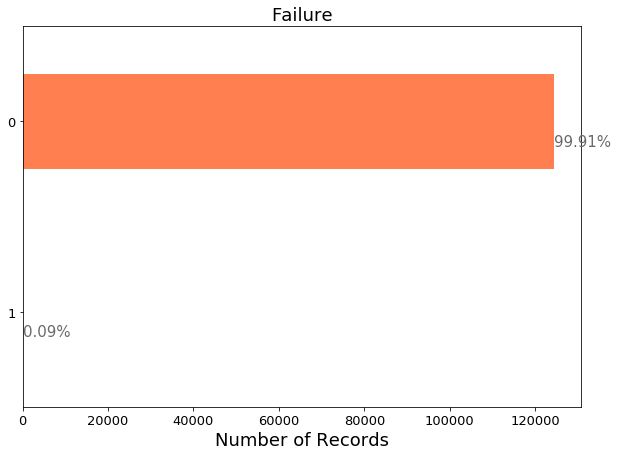

In [5]:
# inspecting the target variable - <1% of failures occured - the dataset is highly imbalanced at a date-device
ax = pred_mnt['failure'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="coral", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Failure", fontsize=18)
ax.set_xlabel("Number of Records", fontsize=18);

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()

In [6]:
#lets see unique values under metrics variables to understand the type and variance
#the date field indicates this is a daily log 
pred_mnt.nunique()

date          304
device       1169
failure         2
metric1    123877
metric2       558
metric3        47
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        65
dtype: int64

In [7]:
#9% -> 106 of 1169 devices failed
#an option to roll up data at a device level (we know from earlier at a date-device level failure is <1%)
pred_mnt[pred_mnt.failure == 1].nunique()

date        76
device     106
failure      1
metric1    106
metric2     48
metric3      7
metric4     40
metric5     28
metric6    105
metric7     16
metric8     16
metric9     14
dtype: int64

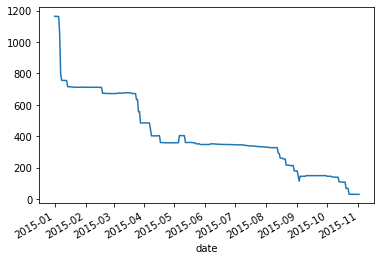

In [8]:
#Visualizing the data by date - no. of logs per day
#no. of logs seems to be decreasing each day
logs_per_day = pred_mnt.groupby('date').date.count()
logs_per_day.plot()

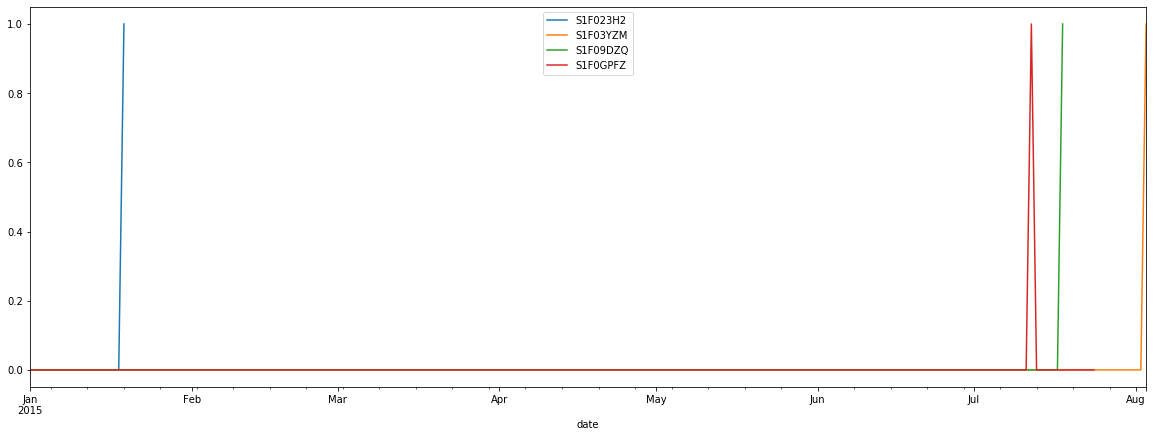

In [9]:
#what does the drop in no. of logs mean?
#1. lets check if devices that fail are removed from the logs list
failed_devices = pred_mnt[pred_mnt.failure == 1].device.unique()
failed_devices.shape
failed_devices_data = pred_mnt[pred_mnt['device'].isin(failed_devices)]

#amongst the subset analysed, there is 1 particular device that has logs post failure
failed_devices_data_eg = failed_devices_data.loc[failed_devices_data['device'].isin(['S1F023H2','S1F09DZQ','S1F03YZM','S1F0GPFZ'])]
failed_devices_data_eg.set_index('date', inplace=True)
failed_devices_data_eg.groupby('device')['failure'].plot(legend = True,figsize=(20,7))
plt.show()


In [10]:
#what % devices continue to have logs post failure? about 5%
left = pd.DataFrame(failed_devices_data[failed_devices_data.failure == 1].groupby('device')['date'].max())
right = pd.DataFrame(failed_devices_data.groupby('device')['date'].max())
result = pd.merge(left, right, on=['device','date'])
(1-len(result)/len(right))

0.047169811320754707

In [11]:
#what does the drop in no. of logs mean?
#only 31 devices have a log on the last day
devices_active = pred_mnt[pred_mnt.date == max(pred_mnt.date)].device.nunique()
devices_active

#1138 of 1169 - 97% devices removed from service
pred_mnt.device.nunique() - devices_active

#how many of them failed amongst those removed for service - only 9%
len(failed_devices)/(pred_mnt.device.nunique() - devices_active)

0.09314586994727592

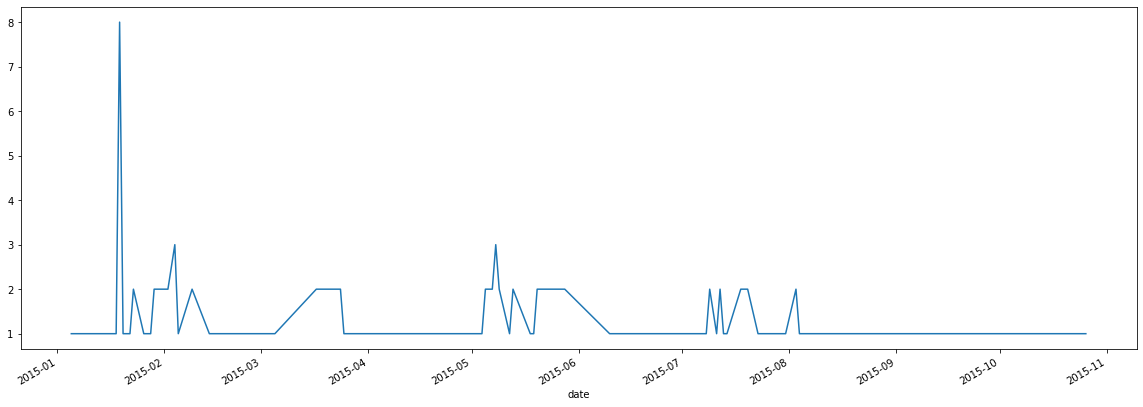

In [12]:
#lets look at the distribution of failures over time
#theres a surge in failure during the beginning of the year
#some peaks until august and then it drops & remains constant till end of year
failed_devices_data[failed_devices_data.failure == 1].groupby('date')['failure'].sum().plot(figsize=(20,7))

             date
count  106.000000
mean   101.066038
std     76.009306
min      5.000000
25%     26.500000
50%     92.000000
75%    148.000000
max    299.000000


28

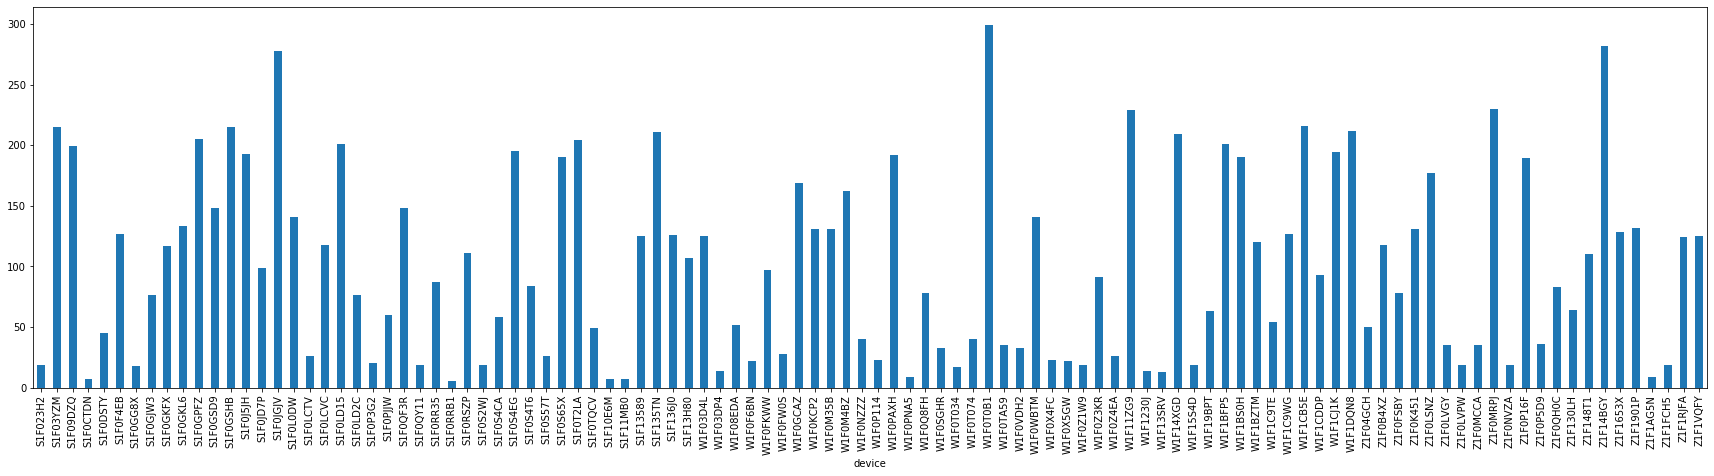

In [13]:
#how many days until devices failed are removed - 101 days on average
failed_devices_data.groupby('device')['date'].count().plot(figsize=(30,7), kind = 'bar')
failed_devices_survival = failed_devices_data.groupby('device')['date'].count()
print(pd.DataFrame(failed_devices_survival).describe())
failed_devices_survival = pd.DataFrame(failed_devices_survival)
len(failed_devices_survival[failed_devices_survival.date < 30])

In [14]:
#how many days until active devices are removed - slightly higher on an average
pred_mnt_survival = pred_mnt[~pred_mnt['device'].isin(failed_devices)].groupby('device')['date'].count()
print(pd.DataFrame(pred_mnt_survival).describe())
pred_mnt_survival = pd.DataFrame(pred_mnt_survival)
len(pred_mnt_survival[pred_mnt_survival.date < 5])

              date
count  1063.000000
mean    107.037629
std     104.950713
min       1.000000
25%       6.000000
50%      84.000000
75%     225.000000
max     304.000000


3

In [15]:
# Plotting the KDE Plot 

# ============ Graphic Function ============ #
def comb_dplot(df, cond1,cond2, col, xlabel, ylabel):
    sns.kdeplot(df.loc[cond1,col], color='r', shade=True, Label='Failed') 
    sns.kdeplot(df.loc[cond2,col], color='b', shade=True, Label='Active') 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    return plt.show()

def comb_dplot_wbin(df, cond1,cond2, col, xlabel, ylabel):
    sns.kdeplot(df.loc[cond1,col], color='r', shade=True, Label='Failed', bw = 1.5) 
    sns.kdeplot(df.loc[cond2,col], color='b', shade=True, Label='Active', bw = 1.5) 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    return plt.show()

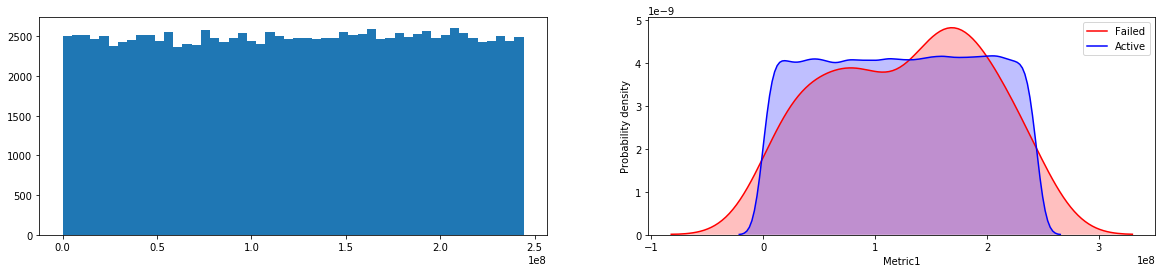

In [16]:
#seems to have high % of unique values
pred_mnt.metric1.nunique()
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.hist(pred_mnt.metric1, bins = 'auto')


#The distribution for failure is bimodal while for non-failures it is uniform
plt.subplot(1,2,2)
comb_dplot(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric1','Metric1','Probability density')



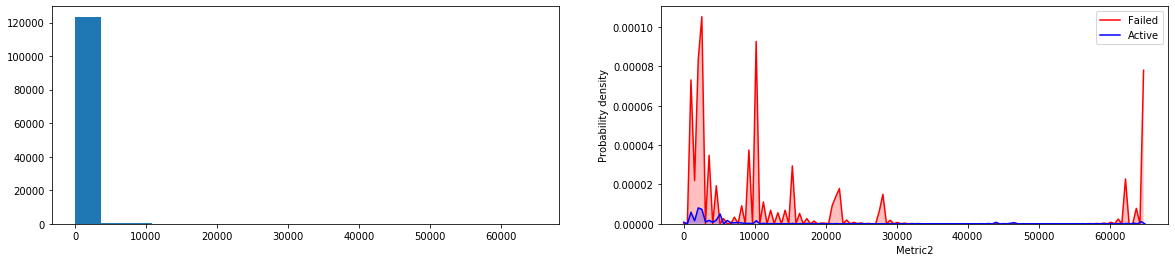

In [17]:
#low varaiance in this varaible
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
#right skewed
plt.hist(pred_mnt.metric2, bins = 'auto')


#Devices with failure show some variation in values for this metric
plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric2','Metric2','Probability density')

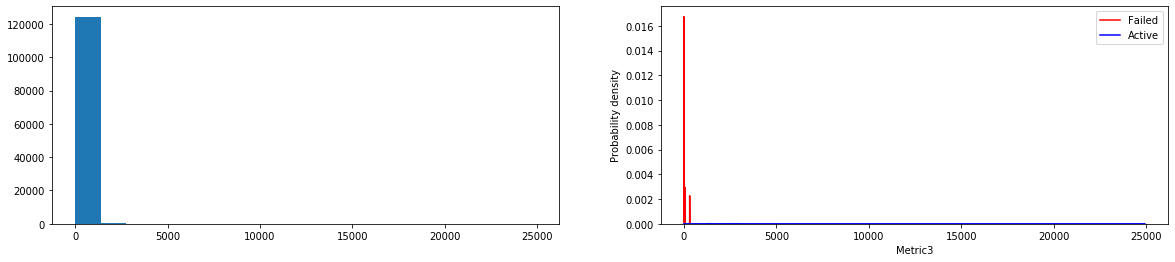

In [18]:
#low varaiance in this varaible as well
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
#right skewed
plt.hist(pred_mnt.metric3, bins = 'auto')

#devices with failure show a high percentage of 0 values
plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric3','Metric3','Probability density')

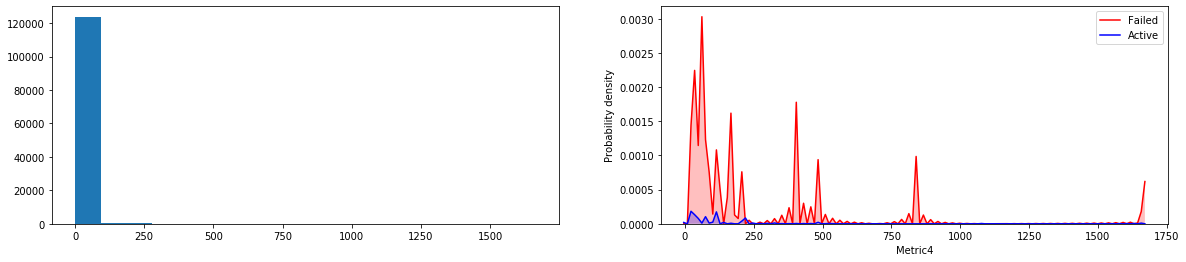

In [19]:
#low varaiance in this varaible as well
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.hist(pred_mnt.metric4, bins = 'auto')

#Devices with failure show some variation in values for this metric
plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric4','Metric4','Probability density')

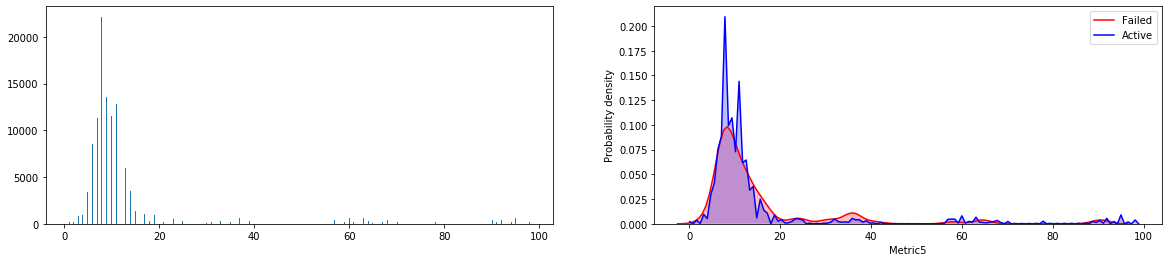

In [20]:
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
#this variable is skewed to the right
plt.hist(pred_mnt.metric5, bins = 'auto')


plt.subplot(1,2,2)
comb_dplot(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric5','Metric5','Probability density')

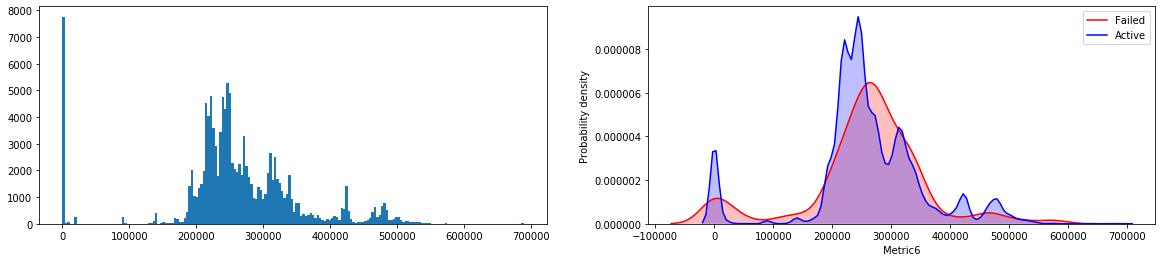

In [21]:
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
#there's a notable spike at the 0 point
plt.hist(pred_mnt.metric6, bins = 'auto')


#The 0 values seem to be mostly associated with devices still active
plt.subplot(1,2,2)
comb_dplot(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric6','Metric6','Probability density')

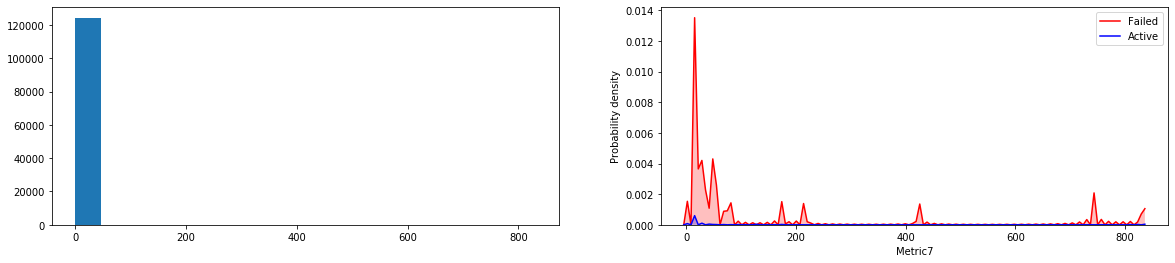

In [22]:
#low varaiance in this varaible as well
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.hist(pred_mnt.metric7, bins = 'auto')

plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric7','Metric7','Probability density')

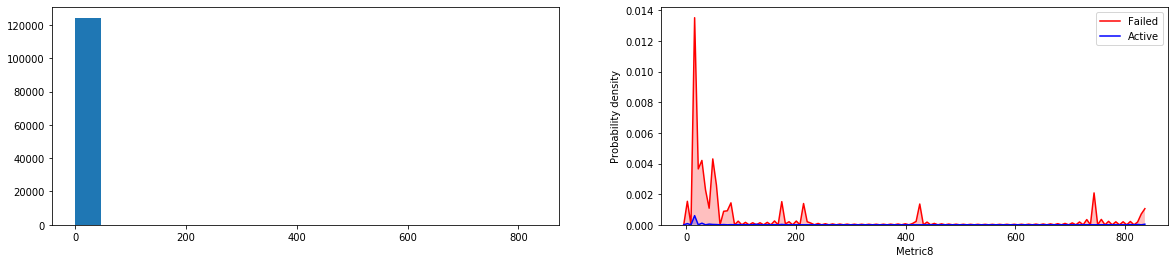

In [23]:
#low varaiance in this varaible as well
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.hist(pred_mnt.metric8, bins = 'auto')

#this ditribution looks exactly same as metric7
plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric8','Metric8','Probability density')

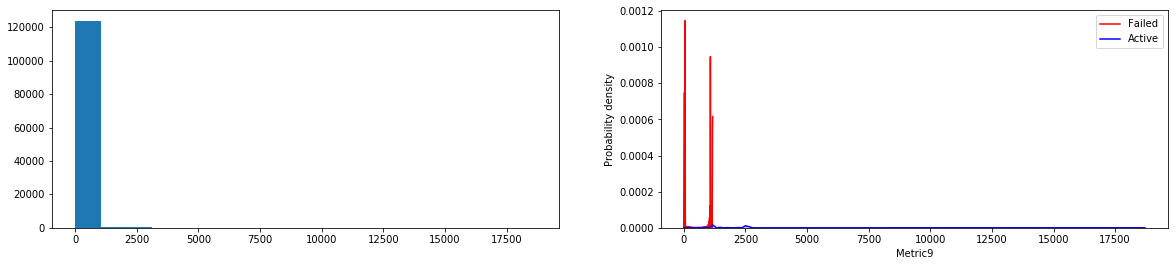

In [24]:
#low varaiance in this varaible as well
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.hist(pred_mnt.metric9, bins = 'auto')

#peaks at 2 points for the failed devices
plt.subplot(1,2,2)
comb_dplot_wbin(pred_mnt,(pred_mnt['failure'] == 1),(pred_mnt['failure'] == 0),
           'metric9','Metric9','Probability density')

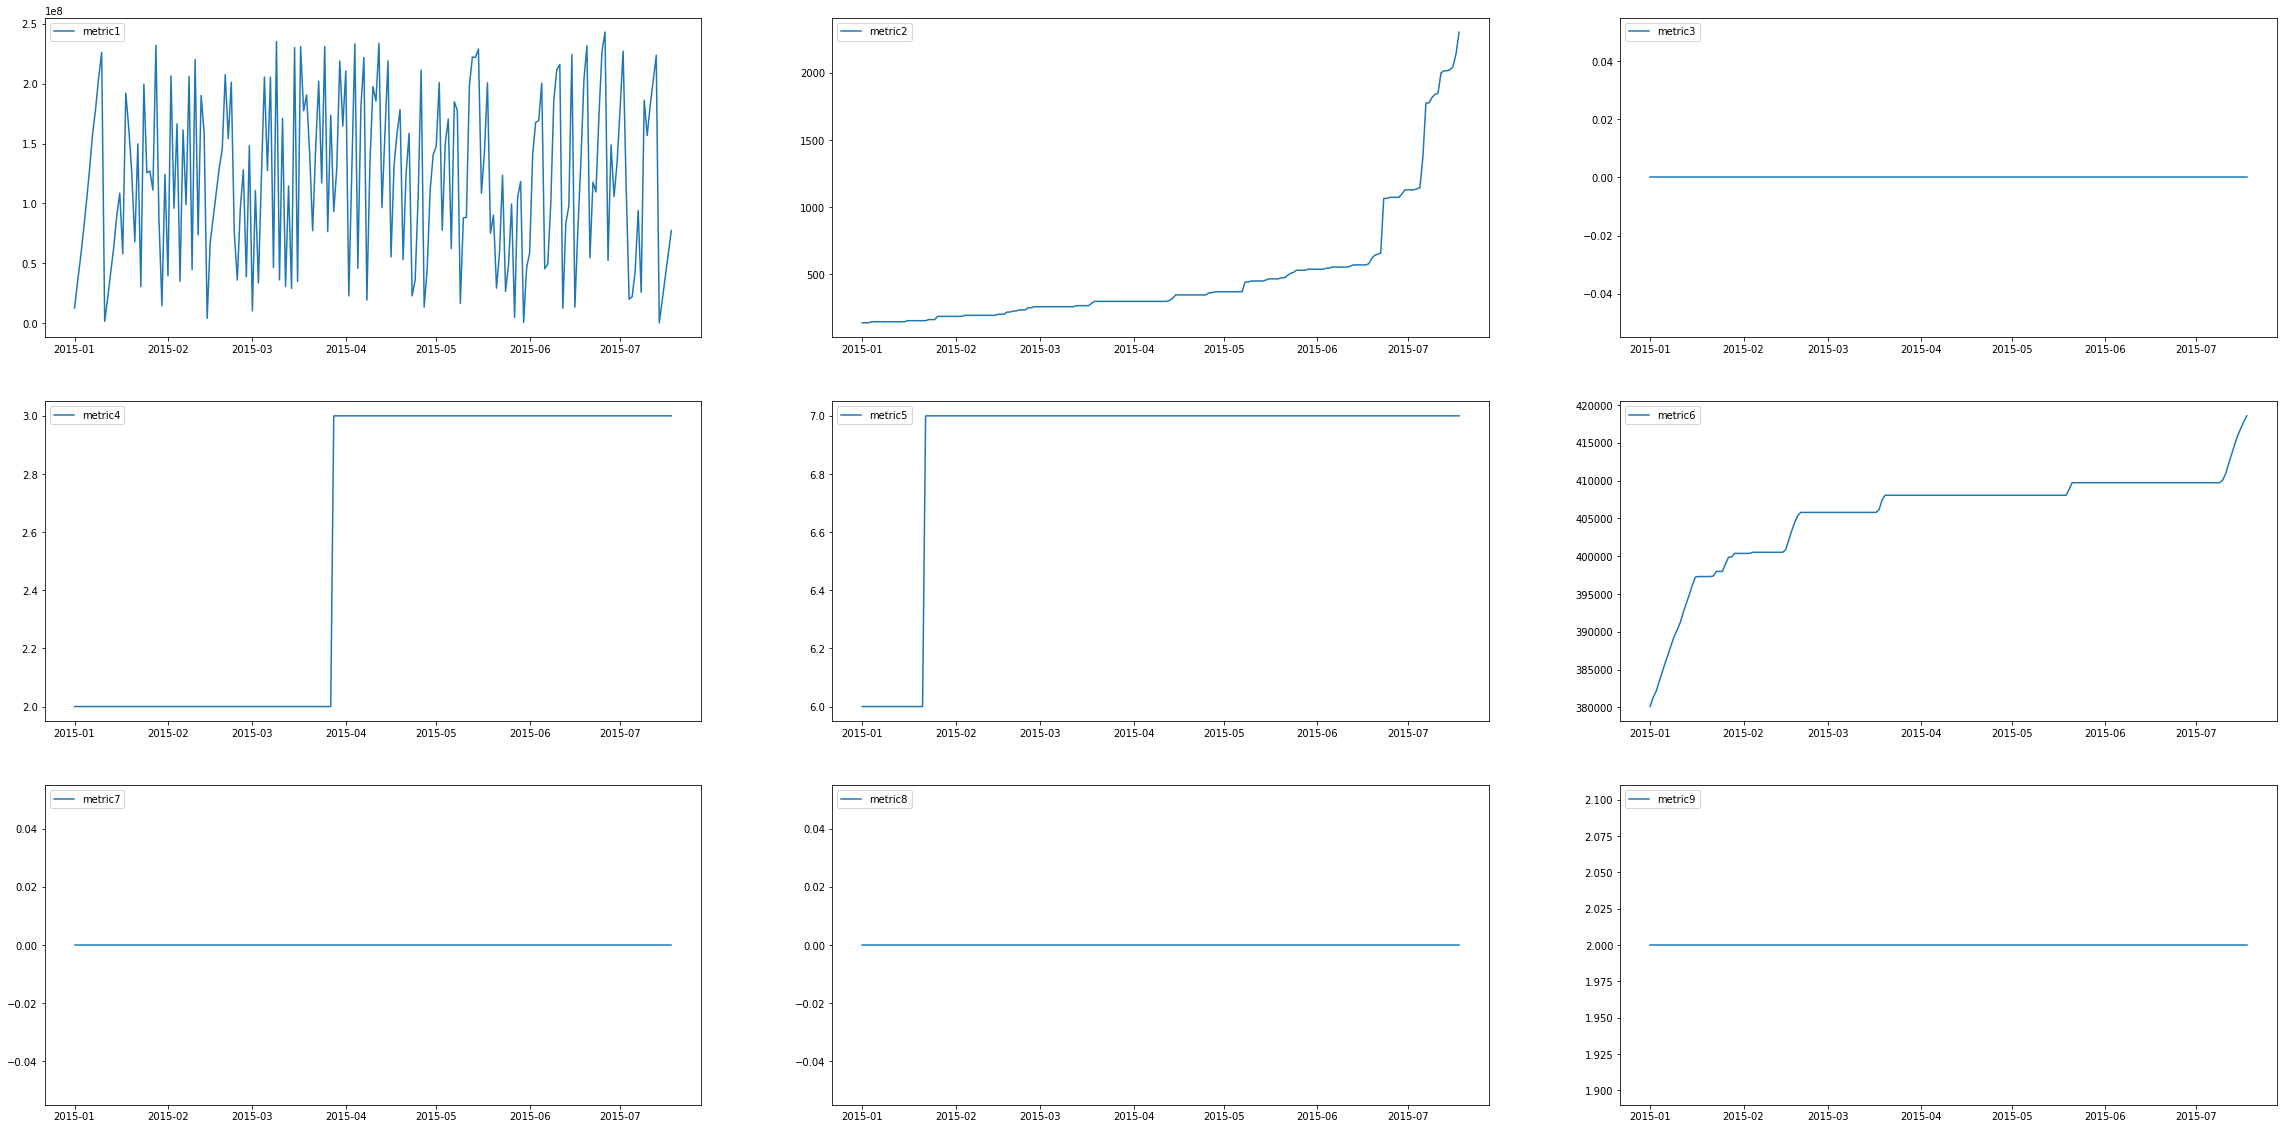

In [25]:
#failed device plot
#metric 2 shows a sudden increase for devices that get close to date of failure
#metrics 3,7,8 and 9 remain constant throughout
#metric 6 shows a gradual increase
fig=plt.figure(figsize=(40,20))
columns = 3
rows = 3

for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    plt.plot(pred_mnt[pred_mnt.device == 'S1F09DZQ'].groupby('date')['metric'+str(i)].sum(), label = 'metric'+str(i))  
    plt.legend(loc="upper left")
plt.show()


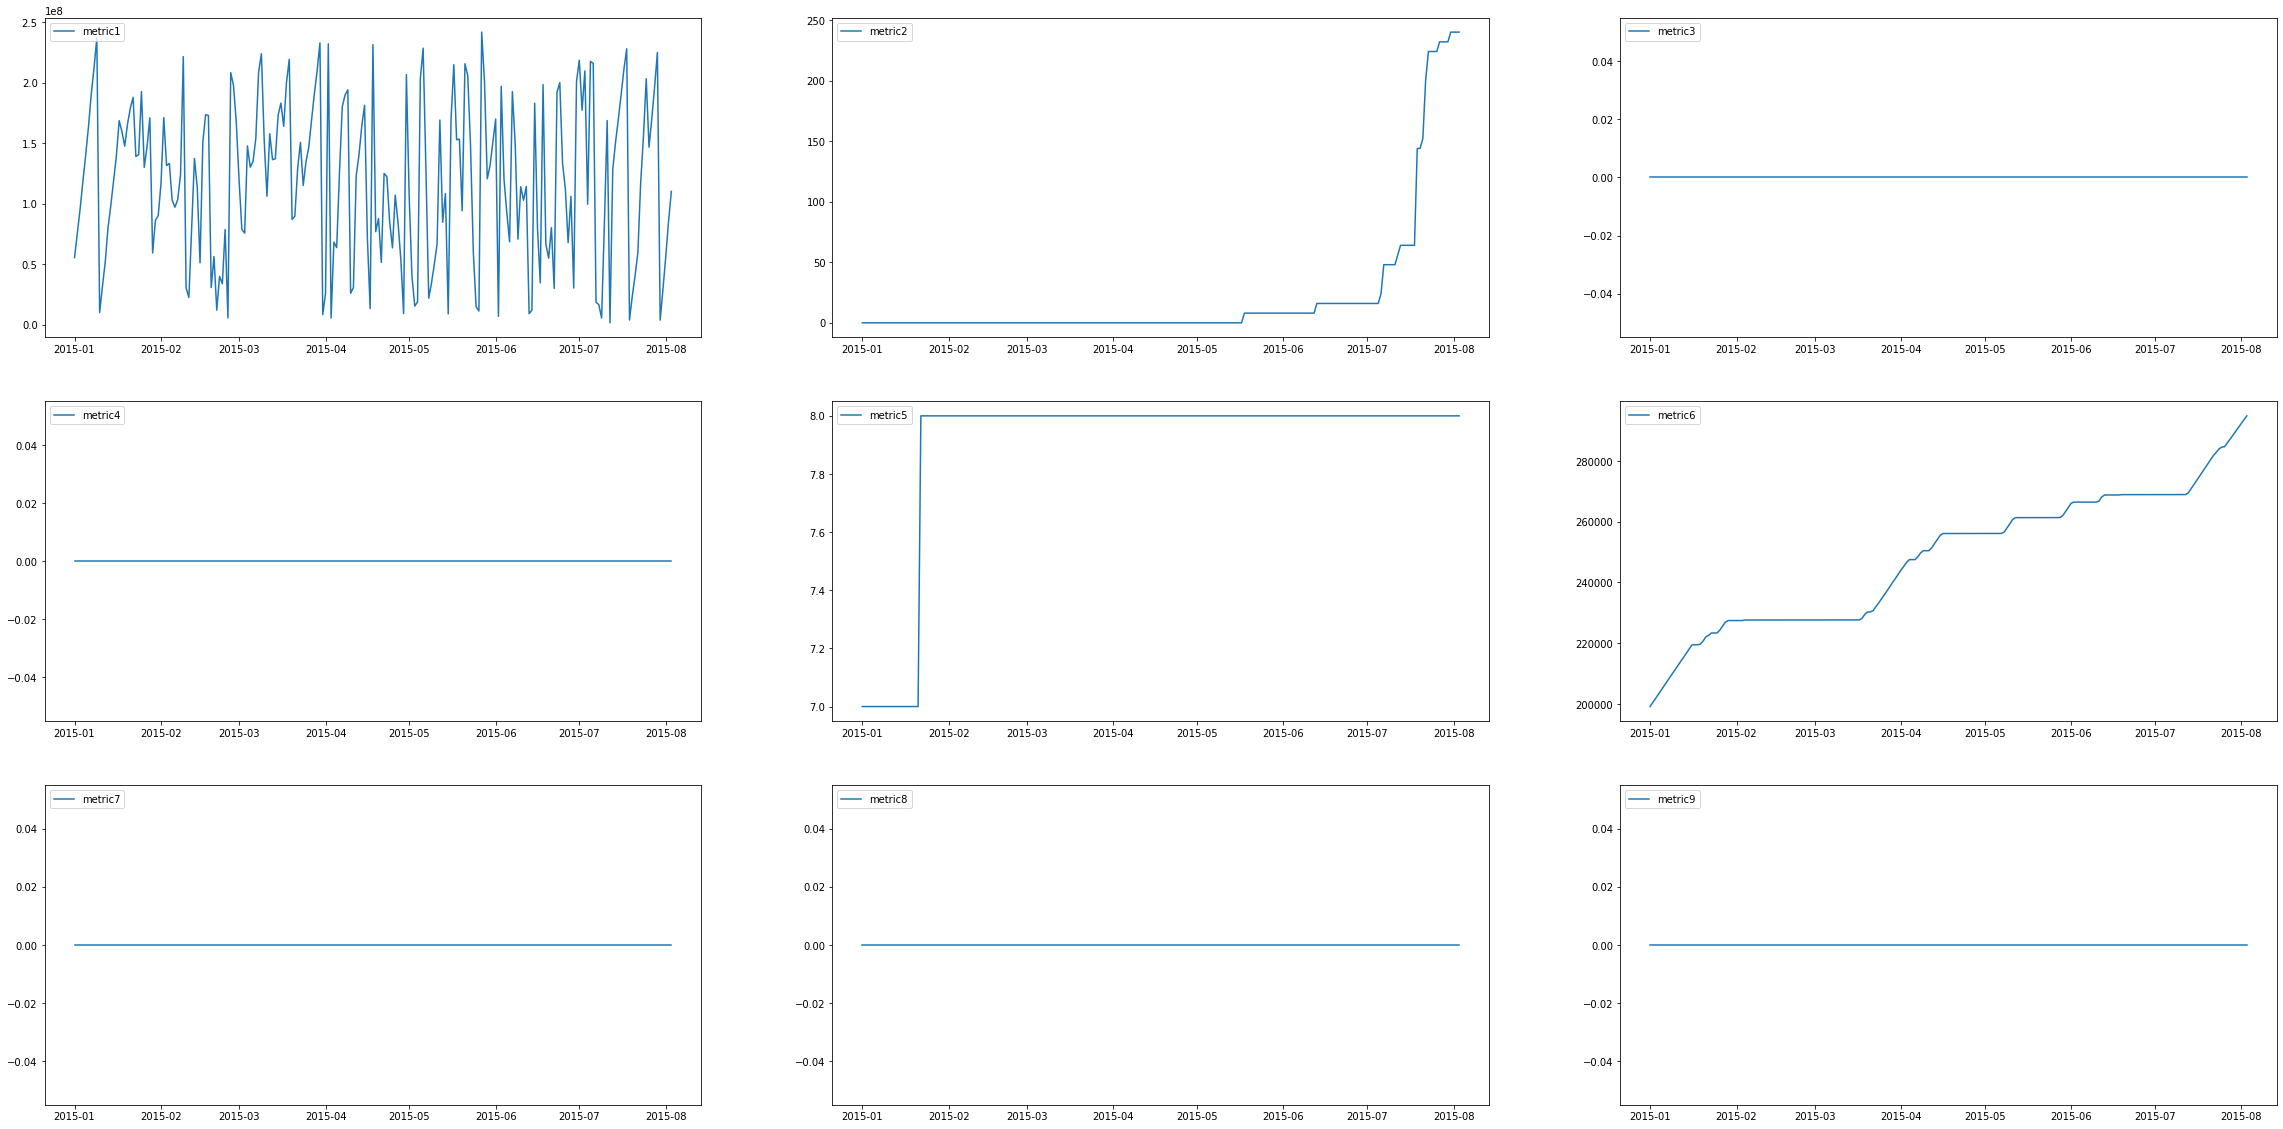

In [26]:
#failed device plot
fig=plt.figure(figsize=(40,20))
columns = 3
rows = 3
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    plt.plot(pred_mnt[pred_mnt.device == 'S1F03YZM'].groupby('date')['metric'+str(i)].sum(), label = 'metric'+str(i))  
    plt.legend(loc="upper left")
plt.show()


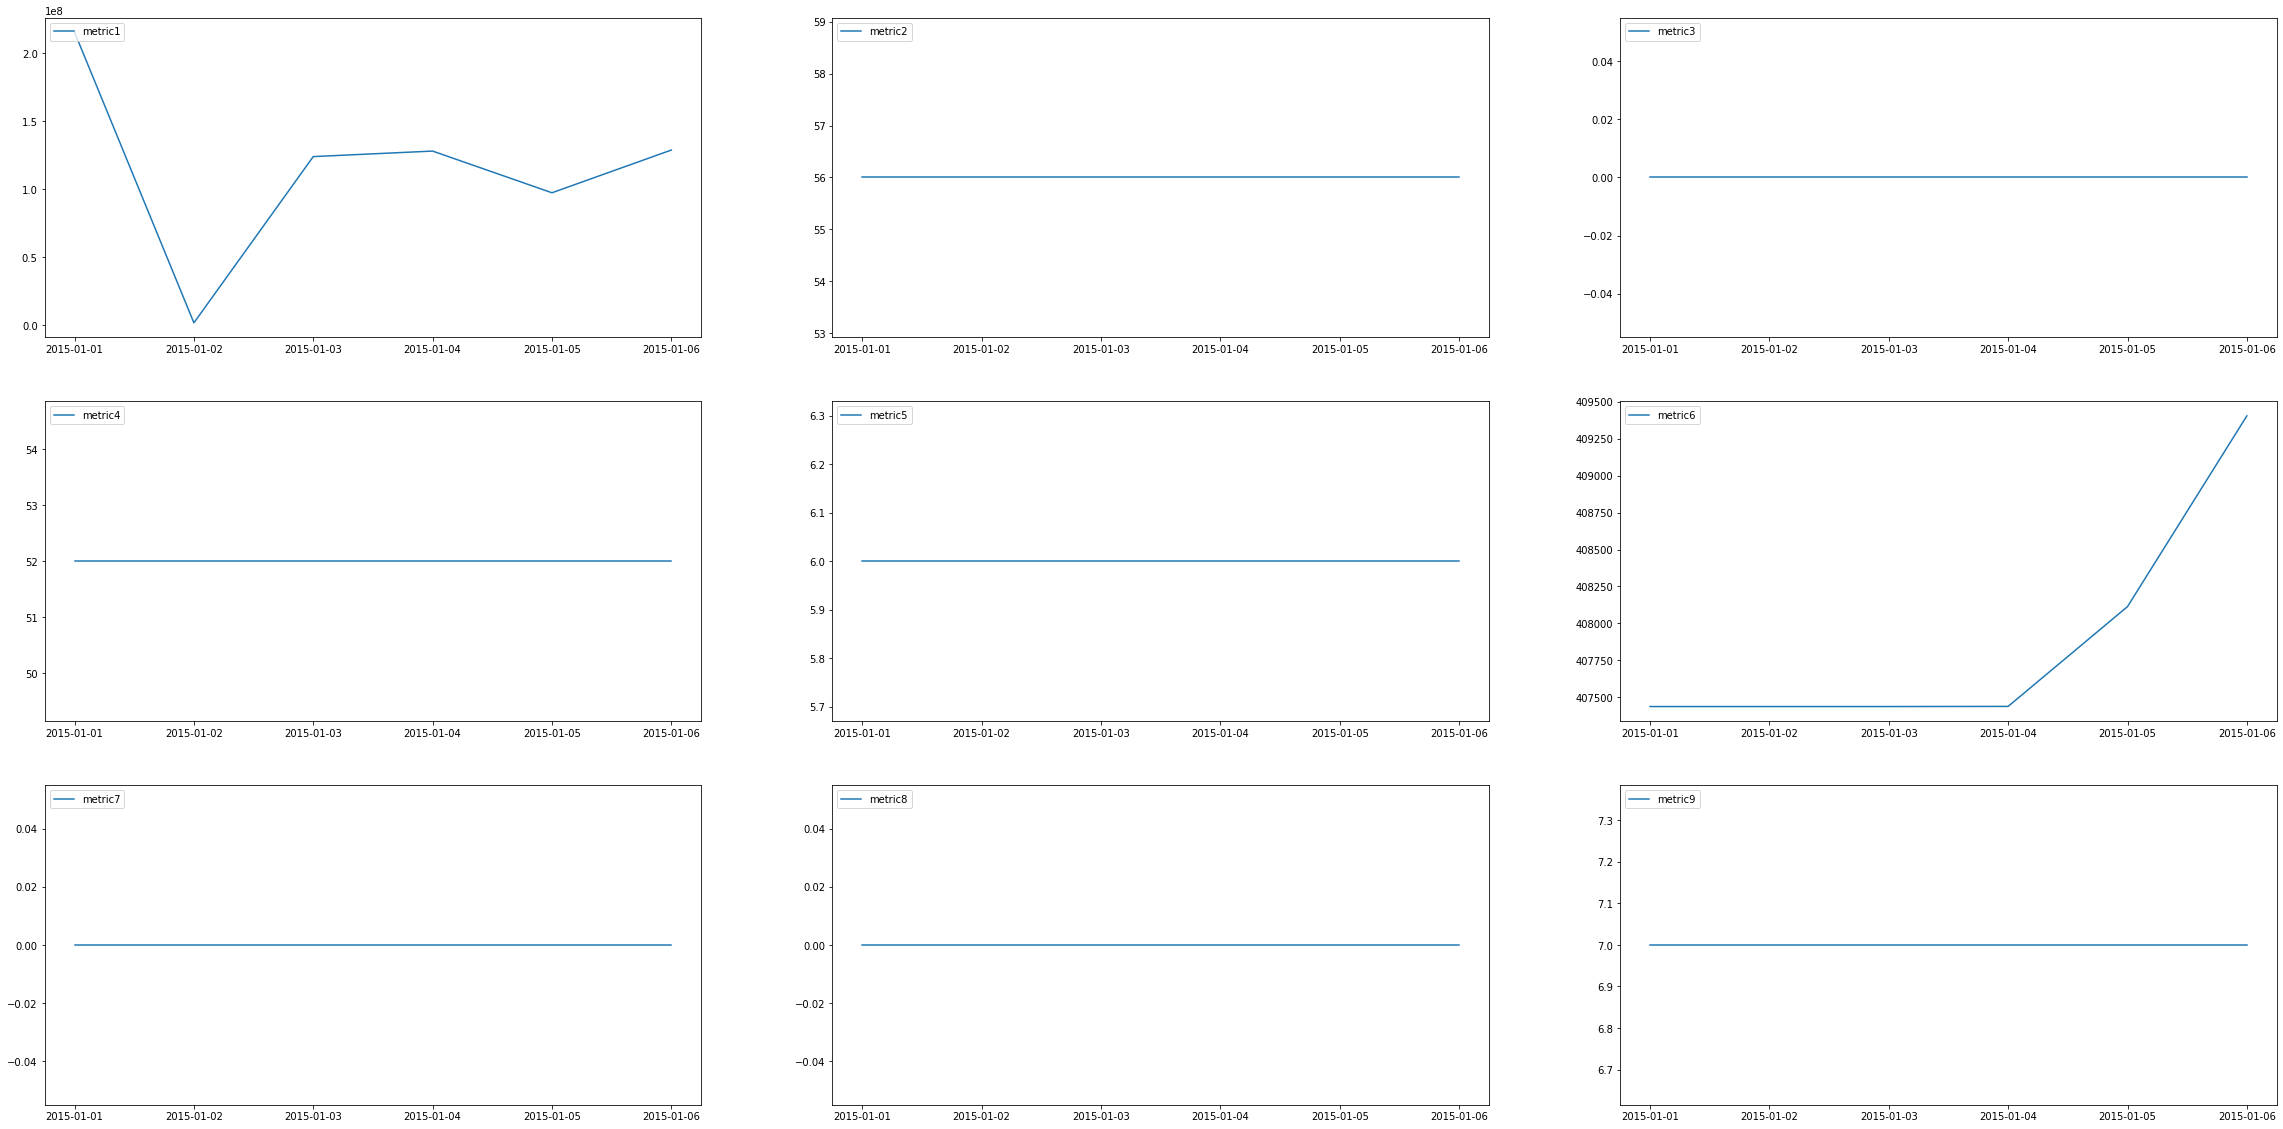

In [27]:
#active device plot
fig=plt.figure(figsize=(40,20))
columns = 3
rows = 3
for i in range(1, 10):
    fig.add_subplot(rows, columns, i)
    plt.plot(pred_mnt[pred_mnt.device == 'S1F01085'].groupby('date')['metric'+str(i)].sum(), label = 'metric'+str(i))  
    plt.legend(loc="upper left")
plt.show()


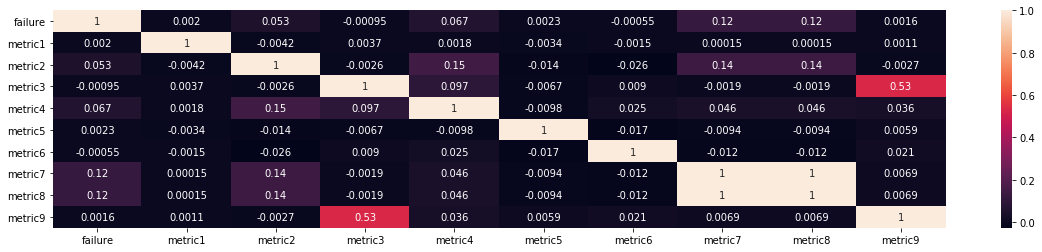

In [28]:
#metric 7 & 8 have a correlation coefficient of 1 - drop metric 8
corrMatrix = pred_mnt.corr()
plt.figure(figsize=(20, 4))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [29]:
#dropping columns that are highly correlated, metric 3 and 9 show moderate correlation
#none of the metrics show strong positive/negative correlation with failure
pred_mnt_mod = pred_mnt.drop(columns = ['metric8'])
pred_mnt_mod.rename(columns={'metric9': 'metric8'}, inplace=True)
pred_mnt_mod

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3
...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0


In [30]:
#no missing values
pred_mnt_mod.isna().mean().round(4) * 100

date       0.0
device     0.0
failure    0.0
metric1    0.0
metric2    0.0
metric3    0.0
metric4    0.0
metric5    0.0
metric6    0.0
metric7    0.0
metric8    0.0
dtype: float64

In [31]:
## input the cycle on interest
def flag_for_fail(df,cycle):
    df['fail_within_' + str(cycle)] = (df.rank_date <= cycle) & (df.fail_status == 1)
    df['fail_within_' + str(cycle)] = df['fail_within_' + str(cycle)].astype(int)
    return df

In [32]:
#there were 5% devices that failed but continued to have logs
#the aim here is to create a variable to understand when a device was last active before they fail & remove residual logs
failed_last_date = left
active_last_date = pd.DataFrame(pred_mnt[~pred_mnt['device'].isin(failed_devices)].groupby('device')['date'].max())
comb_last_date = active_last_date.append(failed_last_date)
comb_last_date['date']= pd.to_datetime(comb_last_date['date'])
comb_last_date.rename(columns={'date': 'last_date'}, inplace=True)

#remove residual logs for failed devices
pred_mnt_mod['date']= pd.to_datetime(pred_mnt_mod['date'])
devices_last_date = pd.merge(pred_mnt_mod, comb_last_date, how='inner', on=['device'])
devices_last_date = devices_last_date[devices_last_date.date <= devices_last_date.last_date]

#Feature Engineering
#create a target variable to predict probability of a device failure within 'x' days
devices_last_date = devices_last_date.groupby(['device','date']).mean()
devices_last_date = devices_last_date.reset_index()
devices_last_date['rank_date'] = devices_last_date.groupby('device')['date'].rank(ascending = 0)
devices_last_date["rank_date"] = devices_last_date["rank_date"].astype(int)
devices_last_date['rev_rank_date'] = devices_last_date.groupby('device')['date'].rank(ascending = 1)
devices_last_date["rev_rank_date"] = devices_last_date["rev_rank_date"].astype(int)
failed_devices = pd.DataFrame(failed_devices, columns = ['device'])
failed_devices["fail_status"] = 1 
data_final = pd.merge(devices_last_date, failed_devices, how='left', on= 'device')
data_final = data_final.fillna(0)
data_final['fail_status'] = data_final['fail_status'].astype(int)

#create target variable
data_final = flag_for_fail(data_final,5)

for col in range(8):
    data_final['metric' + str(col + 1) + '_diffAvg'] = data_final['metric' + str(col + 1)] - data_final.groupby(['device'])['metric' + str(col + 1)].transform('mean')
    data_final['metric' + str(col + 1) + '_diffMed'] = data_final['metric' + str(col + 1)] - data_final.groupby(['device'])['metric' + str(col + 1)].transform('median')
    data_final['metric' + str(col + 1) + '_diffStd'] = data_final['metric' + str(col + 1)] - data_final.groupby(['device'])['metric' + str(col + 1)].transform('std')
    data_final['metric' + str(col + 1) + '_drift'] = data_final['metric' + str(col + 1)] - data_final.groupby(['device'])['metric' + str(col + 1)].transform('first')
data_final

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,metric6_diffStd,metric6_drift,metric7_diffAvg,metric7_diffMed,metric7_diffStd,metric7_drift,metric8_diffAvg,metric8_diffMed,metric8_diffStd,metric8_drift
0,S1F01085,2015-01-01,0,215630672,56,0,52,6,407438,0,...,406643.280993,0,0.0,0,0.0,0,0.0,0.0,7.0,0
1,S1F01085,2015-01-02,0,1650864,56,0,52,6,407438,0,...,406643.280993,0,0.0,0,0.0,0,0.0,0.0,7.0,0
2,S1F01085,2015-01-03,0,124017368,56,0,52,6,407438,0,...,406643.280993,0,0.0,0,0.0,0,0.0,0.0,7.0,0
3,S1F01085,2015-01-04,0,128073224,56,0,52,6,407439,0,...,406644.280993,1,0.0,0,0.0,0,0.0,0.0,7.0,0
4,S1F01085,2015-01-05,0,97393448,56,0,52,6,408114,0,...,407319.280993,676,0.0,0,0.0,0,0.0,0.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124441,Z1F2PBHX,2015-04-02,0,180917784,0,0,0,5,162645,0,...,159167.401076,14637,0.0,0,0.0,0,0.0,0.0,0.0,0
124442,Z1F2PBHX,2015-04-03,0,33952520,0,0,0,5,162645,0,...,159167.401076,14637,0.0,0,0.0,0,0.0,0.0,0.0,0
124443,Z1F2PBHX,2015-04-04,0,59053184,0,0,0,5,162645,0,...,159167.401076,14637,0.0,0,0.0,0,0.0,0.0,0.0,0
124444,Z1F2PBHX,2015-04-05,0,110545440,0,0,0,5,163047,0,...,159569.401076,15039,0.0,0,0.0,0,0.0,0.0,0.0,0


In [33]:
#no missing values in the new predictors created
data_final.isna().mean().round(4) * 100

device             0.0
date               0.0
failure            0.0
metric1            0.0
metric2            0.0
metric3            0.0
metric4            0.0
metric5            0.0
metric6            0.0
metric7            0.0
metric8            0.0
rank_date          0.0
rev_rank_date      0.0
fail_status        0.0
fail_within_5      0.0
metric1_diffAvg    0.0
metric1_diffMed    0.0
metric1_diffStd    0.0
metric1_drift      0.0
metric2_diffAvg    0.0
metric2_diffMed    0.0
metric2_diffStd    0.0
metric2_drift      0.0
metric3_diffAvg    0.0
metric3_diffMed    0.0
metric3_diffStd    0.0
metric3_drift      0.0
metric4_diffAvg    0.0
metric4_diffMed    0.0
metric4_diffStd    0.0
metric4_drift      0.0
metric5_diffAvg    0.0
metric5_diffMed    0.0
metric5_diffStd    0.0
metric5_drift      0.0
metric6_diffAvg    0.0
metric6_diffMed    0.0
metric6_diffStd    0.0
metric6_drift      0.0
metric7_diffAvg    0.0
metric7_diffMed    0.0
metric7_diffStd    0.0
metric7_drift      0.0
metric8_dif

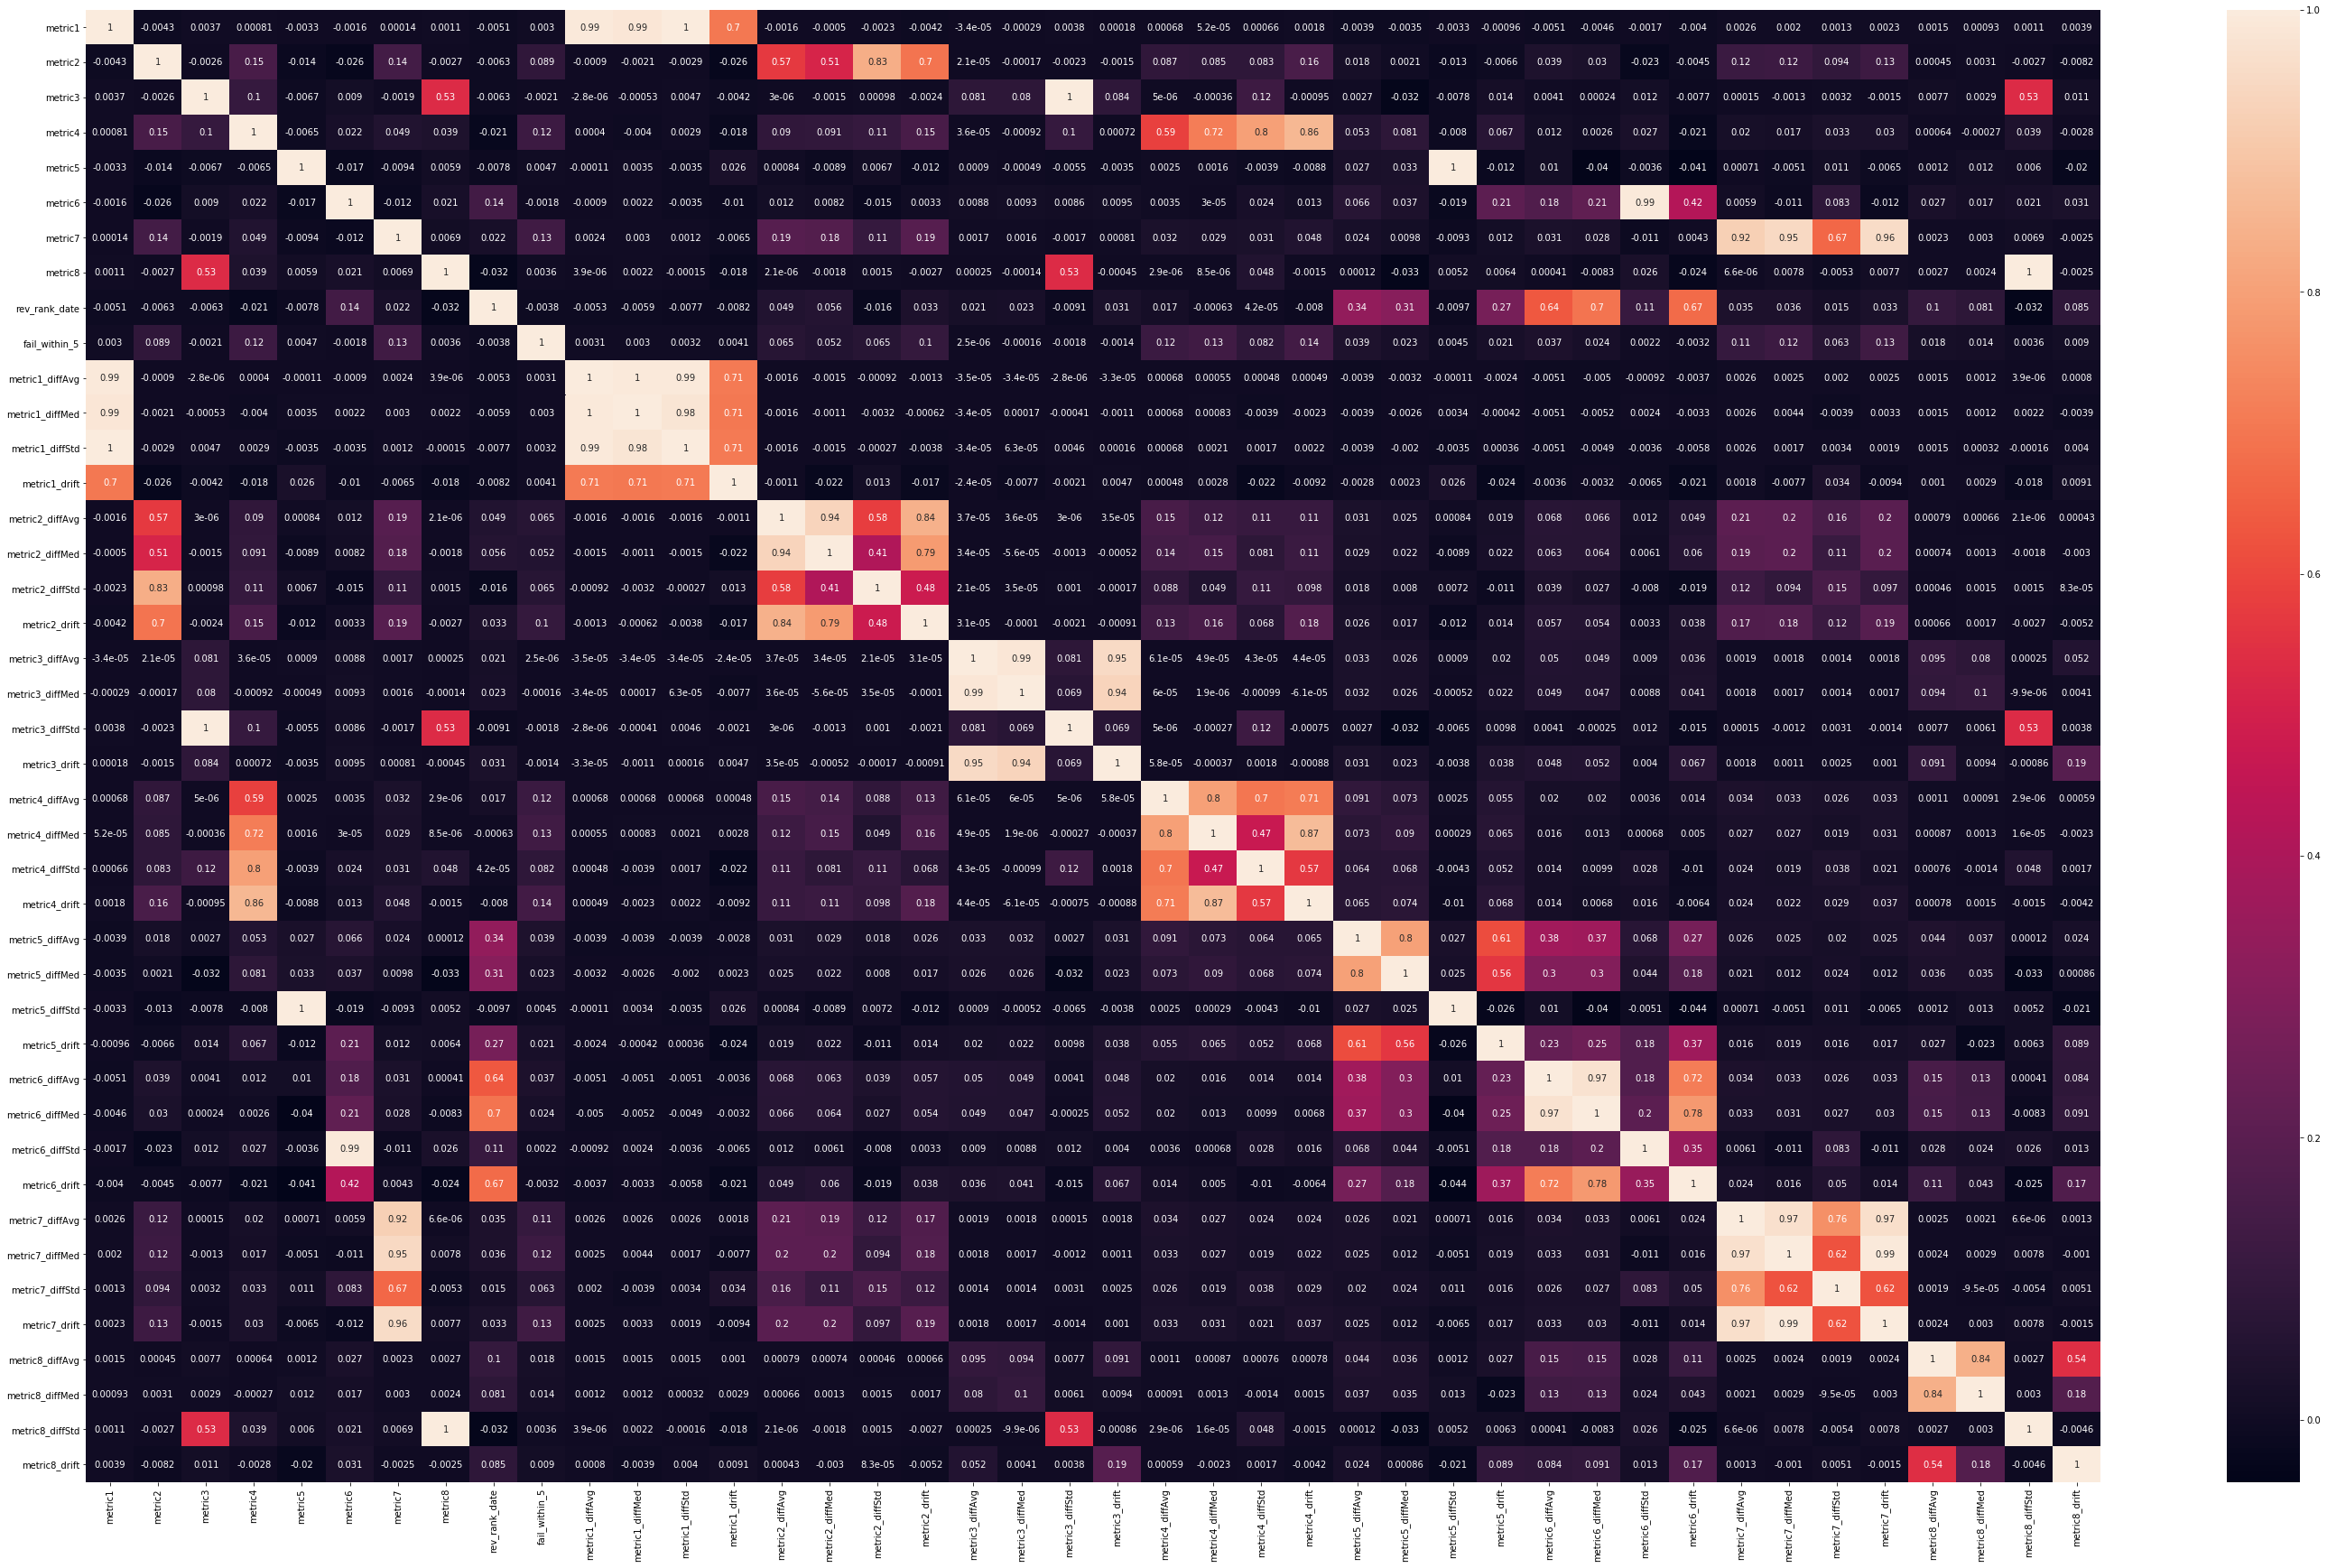

In [34]:
data_final_copy = data_final
data_final_copy.drop(columns=['failure','fail_status'], axis=1, inplace=True)
data_final_copy = data_final_copy.groupby(['device','date']).mean()
data_final_copy
data_final_copy = data_final_copy.drop(columns = ['rank_date'])
corrMatrix = data_final_copy.corr()
plt.figure(figsize=(50, 30))
sns.heatmap(corrMatrix, annot=True)
plt.show()
data_final_copy_cor = data_final_copy

#there is a high correlation amongst predictors derived, remove those over a threshold of +/-0.6
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
correlation(data_final_copy_cor,0.6)

In [35]:
#final dataset we will use for modeling
data_final_copy_cor

metric1  metric2  metric3  metric4  metric5  metric6  \
device   date                                                                 
S1F01085 2015-01-01  215630672       56        0       52        6   407438   
         2015-01-02    1650864       56        0       52        6   407438   
         2015-01-03  124017368       56        0       52        6   407438   
         2015-01-04  128073224       56        0       52        6   407439   
         2015-01-05   97393448       56        0       52        6   408114   
...                        ...      ...      ...      ...      ...      ...   
Z1F2PBHX 2015-04-02  180917784        0        0        0        5   162645   
         2015-04-03   33952520        0        0        0        5   162645   
         2015-04-04   59053184        0        0        0        5   162645   
         2015-04-05  110545440        0        0        0        5   163047   
         2015-04-06  130522432        0        0        0        5   164020   

                     metric7  metric8  rev_rank_date  fail_within_5  \
device   date                                                         
S1F01085 2015-01-01        0        7              1              0   
         2015-01-02        0        7              2              0   
         2015-01-03        0        7              3              0   
         2015-01-04        0        7              4              0   
         2015-01-05        0        7              5              0   
...                      ...      ...            ...            ...   
Z1F2PBHX 2015-04-02        0        0             79              0   
         2015-04-03        0        0             80              0   
         2015-04-04        0        0             81              0   
         2015-04-05        0        0             82              0   
         2015-04-06        0        0             83              0   

                     metric2_diffAvg  metric3_diffAvg  metric4_diffAvg  \
device   date                                                            
S1F01085 2015-01-01              0.0              0.0              0.0   
         2015-01-02              0.0              0.0              0.0   
         2015-01-03              0.0              0.0              0.0   
         2015-01-04              0.0              0.0              0.0   
         2015-01-05              0.0              0.0              0.0   
...                              ...              ...              ...   
Z1F2PBHX 2015-04-02              0.0              0.0              0.0   
         2015-04-03              0.0              0.0              0.0   
         2015-04-04              0.0              0.0              0.0   
         2015-04-05              0.0              0.0              0.0   
         2015-04-06              0.0              0.0              0.0   

                     metric5_diffAvg  metric8_diffAvg  metric8_drift  
device   date                                                         
S1F01085 2015-01-01         0.000000              0.0              0  
         2015-01-02         0.000000              0.0              0  
         2015-01-03         0.000000              0.0              0  
         2015-01-04         0.000000              0.0              0  
         2015-01-05         0.000000              0.0              0  
...                              ...              ...            ...  
Z1F2PBHX 2015-04-02         0.072289              0.0              0  
         2015-04-03         0.072289              0.0              0  
         2015-04-04         0.072289              0.0              0  
         2015-04-05         0.072289              0.0              0  
         2015-04-06         0.072289              0.0              0  

[124446 rows x 16 columns]

In [36]:
# implementing train-test-split
#target variable - fail_within_5, the model will predict if a device will fail within next 5 days
labels = np.array(data_final_copy_cor.pop('fail_within_5'))
X = data_final_copy_cor
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=labels, test_size=0.33, random_state=66)

In [37]:
#function to evaluate model
def evaluate_model(model,data,target,test_data,test_target,test_pred):
    dt_cv_score = cross_val_score(model, data, target, cv=10, scoring='roc_auc')
    print("=== Confusion Matrix ===")
    print(confusion_matrix(test_target, test_pred))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(test_target, test_pred))
    print('\n')
    print("=== All AUC Scores ===")
    print(dt_cv_score)
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score", dt_cv_score.mean())
    print('\n')
    print("=== Precision-Recall Curve ===")
    
    #Precision-Recall curves
    # predict probabilities
    lr_probs = model.predict_proba(test_data)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(test_data)
    lr_precision, lr_recall, _ = precision_recall_curve(test_target, lr_probs)
    lr_f1, lr_auc = f1_score(test_target, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    pyplot.plot(lr_recall, lr_precision, marker='.')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the plot
    pyplot.show()

=== Confusion Matrix ===
[[40867    26]
 [   50   125]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40893
           1       0.83      0.71      0.77       175

    accuracy                           1.00     41068
   macro avg       0.91      0.86      0.88     41068
weighted avg       1.00      1.00      1.00     41068



=== All AUC Scores ===
[0.7181284  0.58815867 0.63202751 0.51830304 0.64315611 0.67105451
 0.61053595 0.66262869 0.53737268 0.5953804 ]


=== Mean AUC Score ===
Mean AUC Score 0.6176745973724576


=== Precision-Recall Curve ===
f1=0.767 auc=0.772


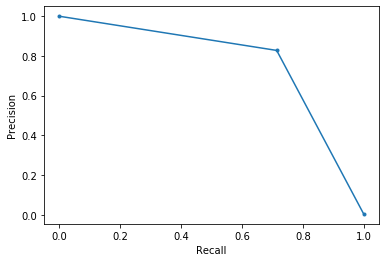

In [38]:
#building a Decision Tree model for classification
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
evaluate_model(dt,X,y,X_test,y_test,y_pred)

In [39]:
#Decision tree feature importance
print("=== Decision Tree Feature Importance ===")
for name, importance in zip(X_train.columns, dt.feature_importances_):
    print(name, "=", importance)

=== Decision Tree Feature Importance ===
metric1 = 0.03651712761924979
metric2 = 0.019162938050995865
metric3 = 0.0027660807909688605
metric4 = 0.033411676245116824
metric5 = 0.03707461748614558
metric6 = 0.1878233335544709
metric7 = 0.04786732227045467
metric8 = 0.03428057246998347
rev_rank_date = 0.2651676251965473
metric2_diffAvg = 0.0840108870118963
metric3_diffAvg = 0.0055475708717671246
metric4_diffAvg = 0.13374029603634704
metric5_diffAvg = 0.09816405891575354
metric8_diffAvg = 0.014465893480302633
metric8_drift = 0.0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=

=== Confusion Matrix ===
[[40883    10]
 [   80    95]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40893
           1       0.90      0.54      0.68       175

    accuracy                           1.00     41068
   macro avg       0.95      0.77      0.84     41068
weighted avg       1.00      1.00      1.00     41068



=== All AUC Scores ===
[0.93462459 0.84510168 0.79860257 0.81276798 0.84595357 0.96241184
 0.82123133 0.89196358 0.82544619 0.8870338 ]


=== Mean AUC Score ===
Mean AUC Score 0.8625137125549523


=== Precision-Recall Curve ===


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


f1=0.679 auc=0.853


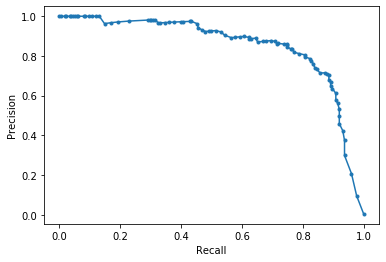

In [40]:
# random forest model creation
rfc_param_tune = RandomForestClassifier(n_estimators=100,
                               bootstrap=True,
                               max_features='sqrt',
                               n_jobs=-1,
                               verbose=1)

rfc_param_tune.fit(X_train,y_train)
rfc_predict = rfc_param_tune.predict(X_test)
evaluate_model(rfc_param_tune,X,y,X_test,y_test,rfc_predict)

In [41]:
#Random Forest feature importance
print("=== Random Forest Feature Importance ===")
for name, importance in zip(X_train.columns, rfc_param_tune.feature_importances_):
    print(name, "=", importance)

=== Random Forest Feature Importance ===
metric1 = 0.11503706418548656
metric2 = 0.04211752837093413
metric3 = 0.009677333064568215
metric4 = 0.052766448753998996
metric5 = 0.06485878703904359
metric6 = 0.17673220527338626
metric7 = 0.06555341057925482
metric8 = 0.03046677923407635
rev_rank_date = 0.1897692420944888
metric2_diffAvg = 0.06542360625108146
metric3_diffAvg = 0.0017981480651557847
metric4_diffAvg = 0.10567560227549716
metric5_diffAvg = 0.06443190772161529
metric8_diffAvg = 0.010123826552228815
metric8_drift = 0.005568110539183884


In [42]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 
steps = 20
model = xgb.train(param, D_train, steps)
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))
print("F1 score = {}".format(f1_score(y_test, best_preds, average='macro')))

Precision = 0.8921238706056545
Recall = 0.5742001250650652
Accuracy = 0.9962014220317522
F1 score = 0.6240479445366663
